In [3]:
import numpy as np
from scipy.sparse import csr_matrix
from deeplp.models.lp import LP
from deeplp.models.data_prep import load_data, prepare_data, random_unlabel, calc_masks
from sklearn.preprocessing import normalize
data = 'cora'
unlabel_prob = 0.99
split_seed = 0

/Users/kojin/anaconda/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def sparse_softmax(x):
    # (1) Applies tf.nn.softmax() to a densified view of each innermost submatrix with shape [B, C], along the size-C dimension; 
    # (2) Masks out the original implicitly-zero locations; 
    # (3) Renormalizes the remaining elements.
    graph = dense_softmax(x.toarray())
    mask = np.zeros(graph.shape,dtype=bool) #np.ones_like(a,dtype=bool)
    mask[[x.tocoo().row,x.tocoo().col]] = True
    graph[~mask] = 0
    graph_normalized = graph / np.sum(graph,axis=1,keepdims=True)
    return csr_matrix((graph_normalized[[x.tocoo().row,x.tocoo().col]], (x.tocoo().row, x.tocoo().col)), shape=(graph.shape))

In [5]:
def dense_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x_smax = x.copy()
    x_smax.data = np.exp(x.data)
    return normalize(x_smax,norm='l1',axis=1)

In [58]:
def run_lp(data,split_seed,thetas=[]):
    true_labels, _, features, node_features, graph_sp = load_data(data,'linqs',directed=1)

    labeled_indices, unlabeled_indices = \
        random_unlabel(true_labels,unlabel_prob,features,
                       seed=split_seed)

    labels, is_labeled = calc_masks(true_labels, labeled_indices, unlabeled_indices, logistic=0)

    if len(thetas) == 0:
        thetas = np.zeros((features.shape[0],1))
    print(features.shape,thetas.shape)
    weights_unnormalized = graph_sp.copy()
    weights_unnormalized.data = np.sum(features * thetas, axis=1)      
    weights = sparse_softmax(weights_unnormalized)

    lp = LP()
    unlabeled_pred = lp.iter_sp(labels,
                         weights,
                         is_labeled,
                         100,
                         unlabeled_indices)

    y_pred = np.argmax(unlabeled_pred,axis=1)
    y_true = np.argmax(true_labels[unlabeled_indices],axis=1)
    log_loss = np.mean(np.sum(-1 * true_labels[unlabeled_indices] * np.log(unlabeled_pred + 0.00001),axis=1))
    entropy = np.mean(np.sum(-1 * unlabeled_pred * np.log(unlabeled_pred + 0.00001),axis=1))
    accuracy = np.mean(y_pred == y_true)
    return weights

In [71]:
w=run_lp('cora',1)

-----------cora-----------
Loading labels...
Loading features...
Loading edge features...
Weights: Asymmetric
Loading graph...
Done!
(10138, 39) (10138, 1)


In [78]:
np.savetxt('org.csv',w.data,delimiter=',')

In [74]:
wopt=run_lp('cora',1,np.array([ -5.21476626e-01, 1.30999064e+00, 1.24373082e-02, 1.98883004e-04
, -4.17887459e-05, 1.07547647e-04,-3.59076425e-04,-8.14575033e-05
, -1.27738080e-04,-2.02997719e-04, 2.54385122e-06, 3.76458658e-04
, -4.77387524e+00, 6.37622870e-05, 1.44023055e-04,-2.15001069e-06
,3.70156849e-05,-1.43914694e-05, 6.22029766e-05,-1.74784029e-04
,1.16765805e-05,-1.18757892e+00, 2.55561972e+00,-1.24702696e-04
,2.08334881e-04, 3.13223124e+00,-1.46998429e+00,-2.49465674e-01
, -1.92462146e+00,-8.09236050e-01,-2.88095927e+00, 8.19547950e-06
,2.67447467e-06, 3.58841899e-05, 2.54785118e-04, 1.58418421e-04
,1.35119236e+00,-6.16346180e-01,-3.06199789e-01]))

-----------cora-----------
Loading labels...
Loading features...
Loading edge features...
Weights: Asymmetric
Loading graph...
Done!
(10138, 39) (39,)


In [79]:
np.savetxt('opt.csv',wopt.data,delimiter=',')

In [67]:
np.array([ -5.21476626e-01,1.30999064e+00,1.24373082e-02,1.98883004e-04
,-4.17887459e-05,1.07547647e-04  -3.59076425e-04  -8.14575033e-05
,-1.27738080e-04  -2.02997719e-04,2.54385122e-06,3.76458658e-04
,-4.77387524e+00,6.37622870e-05,1.44023055e-04  -2.15001069e-06
, 3.70156849e-05  -1.43914694e-05,6.22029766e-05  -1.74784029e-04
, 1.16765805e-05  -1.18757892e+00,2.55561972e+00  -1.24702696e-04
, 2.08334881e-04,3.13223124e+00  -1.46998429e+00  -2.49465674e-01
,-1.92462146e+00  -8.09236050e-01  -2.88095927e+00,8.19547950e-06
, 2.67447467e-06,3.58841899e-05,2.54785118e-04,1.58418421e-04
, 1.35119236e+00  -6.16346180e-01  -3.06199789e-01]).shape

(25,)

In [347]:
def g(x,a,c):
    return 1 / (1 + (a * x / (1 - a * x)) ** (-c))

In [345]:
g(0,1,1)

TypeError: 'property' object is not callable

In [341]:
import matplotlib.pyplot as plt

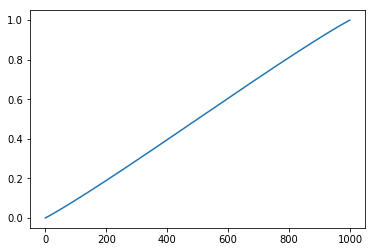

In [422]:
plt.plot([g(x,1.05) for x in np.arange(0.0000001,1-0.0000001,0.001)])
plt.show()

In [373]:
import tensorflow as tf
x = tf.constant(np.random.uniform(size=(100,1)),dtype=tf.float32)
a = tf.Variable(1.0,dtype=tf.float32)
c = tf.Variable(1.0,dtype=tf.float32)

In [374]:
opt = tf.reduce_sum(g(x,a,c))

In [375]:
optimizer = tf.train.AdamOptimizer(0.001)
update = tf.contrib.slim.learning.create_train_op(opt, optimizer,summarize_gradients=True)

INFO:tensorflow:Var Variable has no gradient
INFO:tensorflow:Var Variable_1 has no gradient
INFO:tensorflow:Var Variable_2 has no gradient
INFO:tensorflow:Var Variable_3 has no gradient
INFO:tensorflow:Var Variable_4 has no gradient
INFO:tensorflow:Var Variable_5 has no gradient
INFO:tensorflow:Var Variable_6 has no gradient
INFO:tensorflow:Var Variable_7 has no gradient


In [380]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(update)

In [435]:
import numpy as np
import scipy as sp
from deeplp.models.utils import rbf_kernel
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import softmax

def g(x,c):
    assert (np.any(x == 0.0) or np.any(x == 1.0))
    return 1 / (1 + (x / (1 - x)) ** (-c))
def iter_sp(labels, # input labels
               weights,
               is_labeled,
               num_iter,
               unlabeled_indices,
               clamp=0,
               laplacian=0):
    """Iterated solution of label propagation.
    Input:
        weights: weight adjacency matrix
        is_labeled: boolean indicating labeled nodes
        num_iter: number of iterations of propagation
        unlabeled_indices: indices of unlabeled nodes
    Returns:
        label predictions for the unlabeled nodes
    """


    # normalize T
    Tnorm = normalize(weights, norm='l1', axis=1)
    vals=Tnorm.tocoo().data
    h = labels.copy()

    if laplacian:
        diagonals = np.sum(np.abs(weights),axis=1).T
        offset = [0]
        D = sp.sparse.diags([np.array(np.abs(weights).sum(axis=1).T)[0]], [0])
        Dinv = sp.sparse.linalg.inv(D.tocsc())

        Dinv_sqrt = np.sqrt(Dinv)
        A = Dinv_sqrt @ weights @ Dinv_sqrt

    for i in range(num_iter):
        if not laplacian:
            # propagate labels
            h = Tnorm @ h
            # don't update labeled nodes
            h = h * (1-is_labeled) + labels * is_labeled
        else:
            h = (1-laplacian) * A @ h + laplacian * labels


        
        clamp = g(h,1.1)
#         print(g(np.array([0.1,0.4,0.6]),1.05))
        h = clamp / np.sum(clamp,axis=1,keepdims=True) 
#         print()
#         print(np.sum(h,axis=1).shape,np.sum(h,axis=1))
        print(h[:,0])
#         h = softmax(clamp * h)

    # only return label predictions
    return h[unlabeled_indices]


def _tnorm(weights):
    """Column normalize weights"""
    # row normalize T
    Tnorm = weights / np.sum(weights, axis=1, keepdims=True)
    return Tnorm


In [436]:
# true_labels, _, features, _, \
# graph_sp, _ = load_data(data,directed=1)

# labeled_indices, unlabeled_indices = \
#     random_unlabel(true_labels,unlabel_prob,features,
#                    seed=split_seed)

# labels, is_labeled = calc_masks(true_labels, labeled_indices, unlabeled_indices, logistic=0)

# if len(thetas) == 0:
#     thetas = np.zeros((features.shape[0],1))

# weights_unnormalized = graph_sp.copy()
# weights_unnormalized.data = np.sum(features * thetas, axis=1)    

# weights = sparse_softmax(weights_unnormalized)

unlabeled_pred = iter_sp(labels,
                     weights,
                     is_labeled,
                     100,
                     unlabeled_indices)


y_pred = np.argmax(unlabeled_pred,axis=1)
y_true = np.argmax(true_labels[unlabeled_indices],axis=1)
log_loss = np.mean(np.sum(-1 * true_labels[unlabeled_indices] * np.log(unlabeled_pred + 0.00001),axis=1))
entropy = np.mean(np.sum(-1 * unlabeled_pred * np.log(unlabeled_pred + 0.00001),axis=1))
accuracy = np.mean(y_pred == y_true)

/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':


[0.14285714 0.14285714 0.14285714 ... 0.14285714 0.14285714 0.14285714]
[0.13654171 0.14285714 0.14285714 ... 0.13033748 0.14285714 0.12144526]
[0.13214197 0.14272175 0.14285714 ... 0.12342525 0.1419238  0.10792468]
[0.12858872 0.14202283 0.14285714 ... 0.11269464 0.14151608 0.09326498]
[0.12562936 0.14089362 0.14285714 ... 0.10253186 0.13986646 0.08149289]
[0.12320024 0.13950951 0.14285714 ... 0.09066214 0.13855871 0.06971205]
[0.12089005 0.13771912 0.14296326 ... 0.07869424 0.13602288 0.05927527]
[0.1188323  0.13578825 0.14412493 ... 0.06638189 0.13356291 0.04935232]
[0.11670547 0.133456   0.14514354 ... 0.05463885 0.12989137 0.04055577]
[0.11468352 0.13101422 0.14830051 ... 0.04381762 0.12603563 0.03268835]
[0.11249756 0.12814576 0.15110374 ... 0.03439432 0.12098132 0.02601187]
[0.11032325 0.12514975 0.15696218 ... 0.02653168 0.11553656 0.02041885]
[0.10792219 0.12168393 0.16249361 ... 0.0202388  0.10892864 0.01592456]
[0.10545416 0.11804406 0.17191097 ... 0.01535736 0.10179785 0.01

In [437]:
accuracy

0.6707317073170732